Анализируем pH крови (LBXSPH)


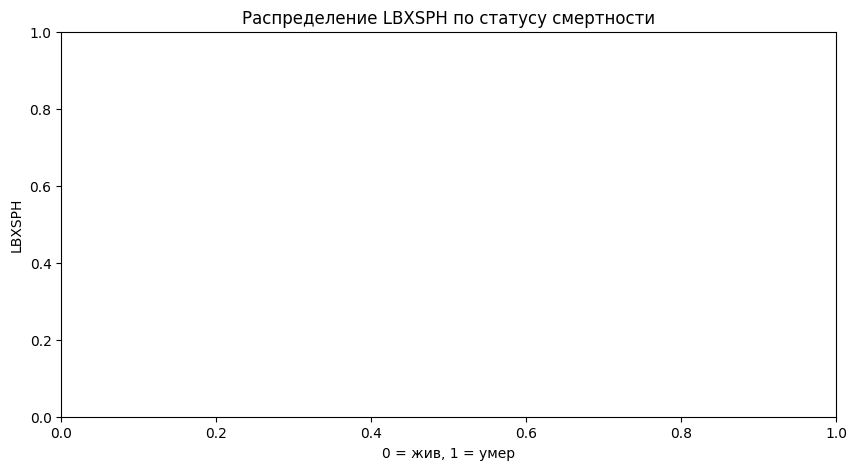


Статистика по LBXSPH:
Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []


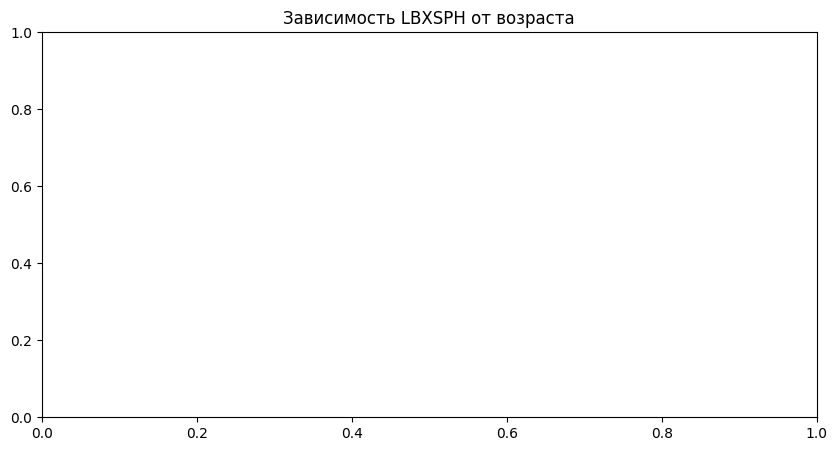

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Загрузка данных
demo = pd.read_sas('DEMO_J.xpt')
labs = pd.read_sas('BIOPRO_J.xpt') 
mort = pd.read_fwf(
    'NHIS_2017_MORT_2019_PUBLIC.dat',
    colspecs=[(0, 7), (8, 9), (10, 11), (12, 18), (19, 25)],
    names=["SEQN", "ELIGSTAT", "MORTSTAT", "PERMTH_INT", "PERMTH_EXM"]
)

# 2. Объединение данных
data = pd.merge(demo, labs, on='SEQN').merge(mort, on='SEQN')
data = data[data['ELIGSTAT'] == 1]

# 3. Выбор показателя для анализа (pH крови как основной маркер)
if 'LBXSPH' in data.columns:
    analysis_col = 'LBXSPH'
    print("Анализируем pH крови (LBXSPH)")
elif 'LBDSPHSI' in data.columns:
    analysis_col = 'LBDSPHSI'
    print("Анализируем pH крови (LBDSPHSI)")
elif 'LBXSAL' in data.columns:
    analysis_col = 'LBXSAL'
    print("Анализируем уровень альбумина (LBXSAL)")
else:
    print("Нет подходящих показателей! Доступные столбцы:")
    print(data.columns.tolist())
    exit()

# 4. Визуализация
plt.figure(figsize=(10, 5))
sns.boxplot(x='MORTSTAT', y=analysis_col, data=data)
plt.title(f'Распределение {analysis_col} по статусу смертности')
plt.xlabel('0 = жив, 1 = умер')
plt.ylabel(analysis_col)
plt.show()

# 5. Статистика
print(f"\nСтатистика по {analysis_col}:")
print(data.groupby('MORTSTAT')[analysis_col].describe())

# Дополнительно: корреляция с возрастом
if 'RIDAGEYR' in data.columns:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x='RIDAGEYR', y=analysis_col, hue='MORTSTAT', data=data)
    plt.title(f'Зависимость {analysis_col} от возраста')
    plt.show()

In [ ]:
if all(col in data.columns for col in ['LBXSOSSI', 'LBXSCL']):
    # Примерная формула: Бикарбонат = Общий CO2 - (Хлориды + 10)
    data['BICARB_EST'] = data['LBXSOSSI'] - (data['LBXSCL'] + 10)
    analysis_col = 'BICARB_EST'

In [6]:
electrolytes = ['LBXSNASI', 'LBXSCL', 'LBXSK']
if all(col in data.columns for col in electrolytes):
    data[electrolytes].plot(kind='box')
    plt.title('Распределение электролитов')
    plt.show()

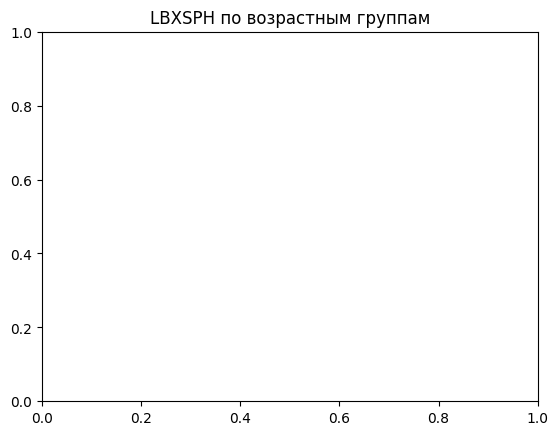

In [7]:
if 'RIDAGEYR' in data.columns:
    data['AGE_GROUP'] = pd.cut(data['RIDAGEYR'], bins=[0, 30, 45, 60, 75, 100])
    sns.boxplot(x='AGE_GROUP', y=analysis_col, hue='MORTSTAT', data=data)
    plt.title(f'{analysis_col} по возрастным группам')
    plt.show()

In [14]:
# Используем библиотеку lifelines
from lifelines import CoxPHFitter, KaplanMeierFitter

# Данные: столбцы 'time' (время наблюдения), 'event' (смерть: 1=да), 'HCO3' (бикарбонат), 'age', 'CKD_stage'
model = CoxPHFitter()
model.fit(data, duration_col='time', event_col='event', covariates=['HCO3', 'age', 'CKD_stage'])

# Визуализация кривых Каплана-Мейера
kmf = KaplanMeierFitter()
kmf.fit(data['time'], data['event'], label='Общая популяция')
kmf.plot_survival_function()
plt.xlabel('Время (дни)')
plt.ylabel('Доля выживших')
plt.show()

ModuleNotFoundError: No module named 'lifelines'

In [10]:
# Визуальная оценка
sns.histplot(data[target_col], kde=True)
plt.show()

NameError: name 'target_col' is not defined